# Homomorphic encryption simulation of Szegedy's semiclassical walk on a cycle graph

In this notebook we show how to simulate the quantum homomorphic encryption of Szegedy's semiclassical walk [[1]](https://www.sciencedirect.com/science/article/pii/S0378437123005769) on a cycle graph using the classical-quantum circuits from [[2]](https://arxiv.org/abs/2412.01966) with CQC-QHE.

## Table of Contents

- [Packages](#0)
- [1 - Naive semiclassical walk simulation](#1)
- [2 - Compiling the quantum circuit into Clifford+T gates](#2)
- [3 - Homomorphic simulation](#3)
- [4 - Simplified homomorphic simulation](#4)
- [5 - Deterministic simulation with SQUWALS](#5)
- [6 - References](#6)

<a name='0'></a>
## Packages
First we import the libraries that we need, including our simulator library.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit.visualization import plot_histogram, plot_distribution

import cqc_qhe as cqc

The code has been tested on qiskit 1.1.0, and qiskit-aer 0.14.1.

In [2]:
import qiskit
qiskit.__version__

'1.1.0'

In [3]:
import qiskit_aer
qiskit_aer.__version__

'0.14.2'

<a name='1'></a>
## 1 - Naive semiclassical walk simulation

First, we construct the circuit that produces the initial state, which represents the initial classical distribution of the semiclassical walk, and is run by Client.

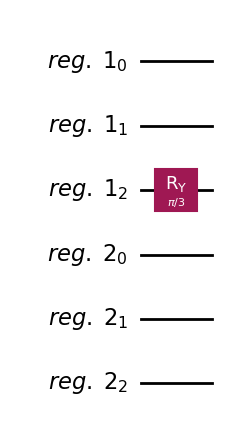

In [4]:
qr_1 = QuantumRegister(3,'reg. 1')
qr_2 = QuantumRegister(3,'reg. 2')

init_circ = QuantumCircuit()
init_circ.add_register(qr_1)
init_circ.add_register(qr_2)

p1 = 0.25
th = 2*np.arccos(np.sqrt(1-p1))
init_circ.ry(th,qr_1[-1])
init_circ.draw('mpl')

Create the circuit of the update operator $V$.

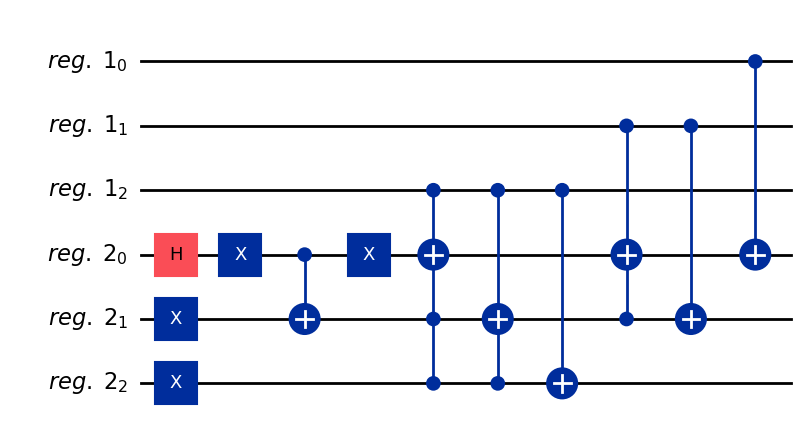

In [5]:
update_circ = QuantumCircuit()
update_circ.add_register(qr_1)
update_circ.add_register(qr_2)

update_circ.h(3)
update_circ.x(4)
update_circ.x(5)

update_circ.x(3)
update_circ.cx(3,4)
update_circ.x(3)

update_circ.mcx([2,4,5],3)
update_circ.mcx([2,5],4)
update_circ.cx(2,5)

update_circ.mcx([1,4],3)
update_circ.cx(1,4)

update_circ.cx(0,3)

update_circ.draw('mpl')

Create the circuit for the unitary evolution $U_w$.

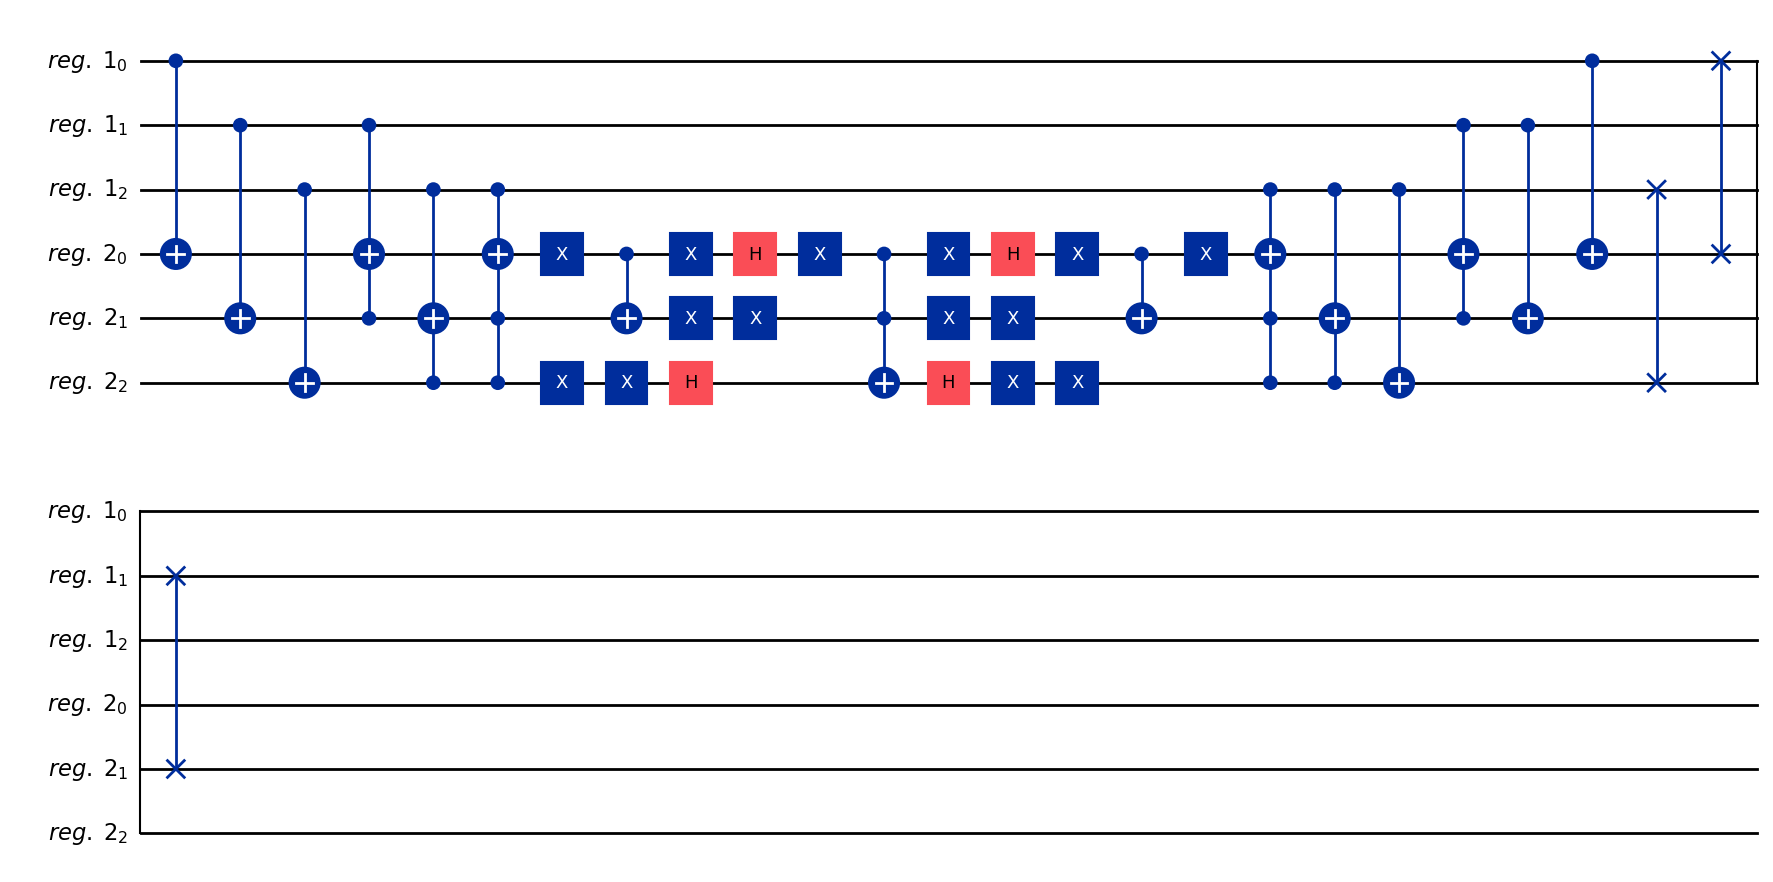

In [6]:
unitary_circ = QuantumCircuit()

unitary_circ.add_register(qr_1)
unitary_circ.add_register(qr_2)

unitary_circ = unitary_circ.compose(update_circ.inverse())
unitary_circ.x([3,4,5])
unitary_circ.h(5)
unitary_circ.ccx(3,4,5)
unitary_circ.h(5)
unitary_circ.x([3,4,5])
unitary_circ = unitary_circ.compose(update_circ)

unitary_circ.swap([0,1,2],[3,4,5])

unitary_circ.draw('mpl')

We create the circuits that Server must run for each classical time step. Since the simulation is performed until $t_c=10$ classical steps, we have 11 circuits, taking also into account $t_c=0$. These circuits have a residual classical register for the intermediate measurements.

The quantum evolution is performed for $t_q=2$ quantum steps.

In [7]:
def create_main_circ(unitary_circ,update_circ,quantum_time,final_classical_time):
    
    # Obtain the quantum registers.
    registers = []
    for a in range(len(unitary_circ.qubits)):
        r = unitary_circ.find_bit(unitary_circ.qubits[a]).registers[0][0]
        if r not in registers:
            registers.append(r)

    main_circ = QuantumCircuit()
    for a in range(len(registers)):
        main_circ.add_register(registers[a])
    
    # Take the two register of Szegedy's circuit.
    qr_1 = registers[0]
    qr_2 = registers[1]
    
    # Create a classical register for the intermediate measurements.
    residual = ClassicalRegister(1,'res')
    main_circ.add_register(residual)
    
    # Perform each classical step.
    for tc in range(final_classical_time):
        
        # Measure the first register.
        for a in range(len(qr_1)):
            main_circ.measure(qr_1[a],residual[0])
        
        # Reset the second register.
        main_circ.reset(qr_2)
        main_circ.barrier()
    
        # Apply the update operator.
        main_circ = main_circ.compose(update_circ)
        main_circ.barrier()
        
        # Apply the quantum evolution.
        for tq in range(quantum_time):
            main_circ = main_circ.compose(unitary_circ)
            main_circ.barrier()
        main_circ.barrier()
        main_circ.barrier()
    
    return main_circ

quantum_time = 2
final_classical_time = 10
main_circs = [create_main_circ(unitary_circ,update_circ,quantum_time,tc) for tc in range(0,final_classical_time+1)]

# main_circs[2].draw('mpl')

We compose the circuits to check that the semiclassical walk algorithm works.

In [8]:
# Compose the circuits.
simulation_circs = [main_circ.compose(init_circ,qubits=init_circ.qubits,front=True) for main_circ in main_circs]

# Set the qubits for the results.
measured_qubits = qr_1

# Measure the qubits in a classical register.
circ_classical_reg = ClassicalRegister(len(measured_qubits),'circ')
for simulation_circ in simulation_circs:
    simulation_circ.add_register(circ_classical_reg)
    simulation_circ.barrier()
    simulation_circ.measure(measured_qubits,circ_classical_reg)

# simulation_circs[1].draw('mpl')

Qiskit uses little-endian order for the bits, so that when measuring, the first bit in the result is the one at bottom. However, in our library CQC-QHE [[2]](https://arxiv.org/abs/2412.01966) we use big-endian order, so that the uppermost bit is the first one. To obtain the results in the correct order, we use our function ``run``.

In [9]:
shots = 100
# shots = 1024  # This takes too much time.
# shots = 20000  # This takes extremely too much time.

counts = [cqc.run_circuit(circ,shots) for circ in simulation_circs]

The results we are interested in are in the last classical register. We take the counts of this classical register with the function ``last_register_counts``.

In order to convert the counts into probability distributions, we use the helper function ``counts_to_probability_distribution``.

We construct a function that performs these conversions for each classical step, resulting in a matrix where each row is the probability distribution of each classical step.

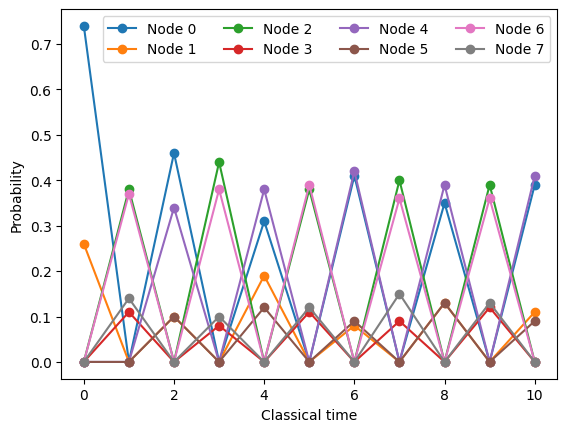

In [10]:
def counts_to_step_probability_distributions(counts):

    # Take the last register of the counts, which corresponds to the measurements we are interested in.
    last_counts = [cqc.last_register_counts(step_counts) for step_counts in counts]

    # Take the number of elements in the computational basis.
    N = 2**(len(list(last_counts[0].keys())[0]))

    distributions_matrix = np.zeros([final_classical_time+1,N])

    for tc in range(final_classical_time+1):

        step_counts = last_counts[tc]
        probability_distribution = cqc.counts_to_probability_distribution(step_counts)

        distributions_matrix[tc] = probability_distribution
    
    return distributions_matrix

distributions_matrix = counts_to_step_probability_distributions(counts)

plt.plot(distributions_matrix,'-o')
plt.xlabel('Classical time')
plt.ylabel('Probability')
plt.legend(['Node '+str(n) for n in range(distributions_matrix.shape[1])],ncols=4,loc=1)
plt.show()

<a name='2'></a>
## 2 - Compiling the quantum circuit into Clifford+T gates

For the homomorphic simulation we need the main circuits that Server must run to be compiled into Clifford+T gates. We use our function ``compile_clifford_t_circuit``.

In [11]:
compiled_main_circs = [cqc.compile_clifford_t_circuit(main_circ) for main_circ in main_circs]

# compiled_main_circs[1].draw('mpl')

Now, the circuits are composed of Clifford+T gates. We compose them again with the initial circuit of Client to check that the algorithm works.

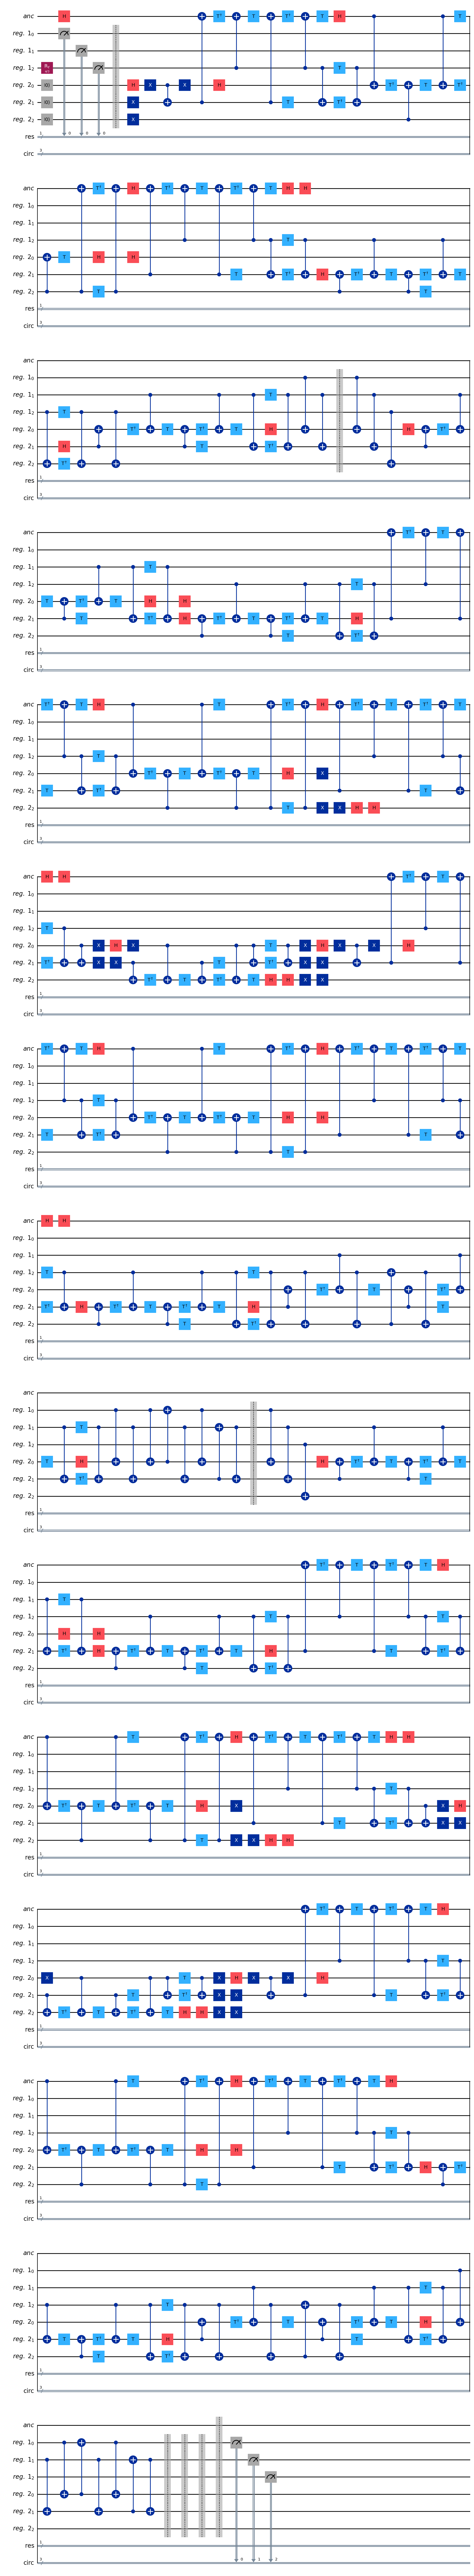

In [12]:
# Compose the circuits.
compiled_simulation_circs = [main_circ.compose(init_circ,qubits=init_circ.qubits,front=True) for main_circ in compiled_main_circs]

# Set the qubits for the results.
measured_qubits = qr_1

# Measure the qubits in a classical register.
circ_classical_reg = ClassicalRegister(len(measured_qubits),'circ')
for compiled_simulation_circ in compiled_simulation_circs:
    compiled_simulation_circ.add_register(circ_classical_reg)
    compiled_simulation_circ.barrier()
    compiled_simulation_circ.measure(measured_qubits,circ_classical_reg)

compiled_simulation_circs[1].draw('mpl')

We obtain the same resuts as before when measuring.

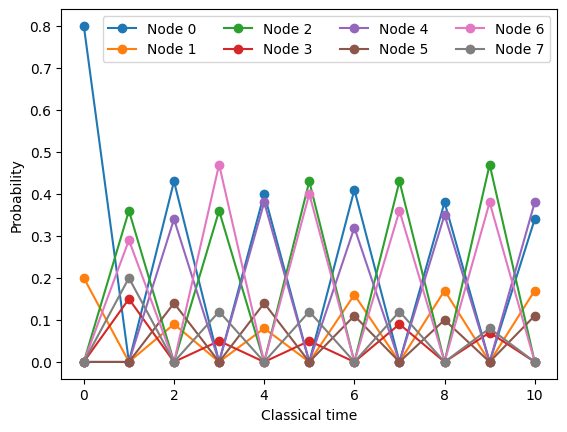

In [13]:
compiled_counts = [cqc.run_circuit(circ,shots) for circ in compiled_simulation_circs]

compiled_distributions_matrix = counts_to_step_probability_distributions(compiled_counts)

plt.plot(compiled_distributions_matrix,'-o')
plt.xlabel('Classical time')
plt.ylabel('Probability')
plt.legend(['Node '+str(n) for n in range(distributions_matrix.shape[1])],ncols=4,loc=1)
plt.show()

<a name='3'></a>
## 3 - Homomorphic simulation

For the homomorphic simulation, we need to create a circuit that first implements the initial circuit of Client, then the circuit of Sever with the appropiate rules for the $T/T^\dagger$ gates and creation of Bell pairs in the ancilla qubits, and finally the circuit of Client that updates the keys and measures the final state.

We use the function ``create_homomorphic_circuit``.

In [14]:
homomorphic_circuits = [cqc.create_homomorphic_circuit(init_circ,compiled_main_circ,measured_qubits) for compiled_main_circ in compiled_main_circs]

[len(homomorphic_circuits[tc].qubits) for tc in range(final_classical_time+1)]

[6, 385, 763, 1141, 1519, 1897, 2275, 2653, 3031, 3409, 3787]

In this case, since there is a lot of $T/T^\dagger$ gates due to the multicontrolled gates, the number of qubits is extremely big. Thus, we cannot perform a classical simulation with Qiskit. We need to use the simplified simulation method.

<a name='4'></a>
## 4 - Simplified homomorphic simulation

In the supplementary material of [[2]](https://arxiv.org/abs/2412.01966) we show a method for simplifying the simulation using only 2 qubits for all the $T/T^\dagger$ gates. We create this simplified circuit with the function ``create_simplified_homomorphic_circuit``. Now the circuits contain only $9$ qubits.

In [15]:
simplified_homomorphic_circuits = [cqc.create_simplified_homomorphic_circuit(init_circ,compiled_main_circ,measured_qubits) for compiled_main_circ in compiled_main_circs]

# simplified_homomorphic_circuits[2].draw('mpl')
[len(simplified_homomorphic_circuits[tc].qubits) for tc in range(final_classical_time+1)]

[8, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9]

We run the circuits. As we have two additional qubits, and the emulation of classical gates is done by means of classical gates, it takes far more time than before.

In [16]:
simplified_homomorphic_counts = [cqc.run_circuit(circ,shots) for circ in simplified_homomorphic_circuits]

In this case, the results have several classical registers in the bitstrings. The measurements of the qubits of the main circuit correspond again to the last register. We take the probability distributions of the last register for each classical step using again the previous function ``counts_to_step_probability_distributions``.

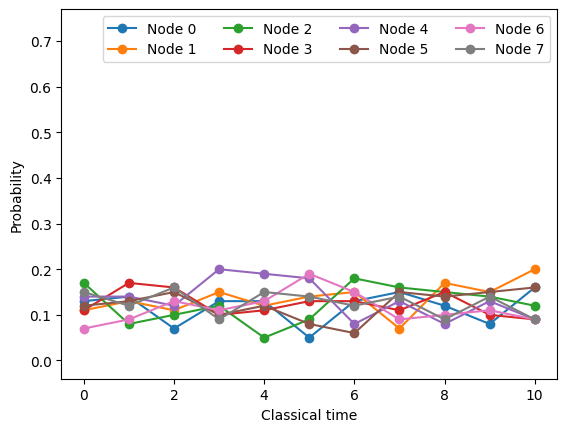

In [17]:
simplified_encrypted_distributions_matrix = counts_to_step_probability_distributions(simplified_homomorphic_counts)

plt.plot(simplified_encrypted_distributions_matrix,'-o')
plt.xlabel('Classical time')
plt.ylabel('Probability')
plt.legend(['Node '+str(n) for n in range(distributions_matrix.shape[1])],ncols=4,loc=1)
plt.ylim([-0.04,0.77])
plt.show()

The results are encrypted, so we do not obtain the correct results obtained before. We decrypt them with the function ``decrypt_counts``.

The measured positions for $t_c=0$ are $[0,1,2]$, corresponding to the first register. For the rest of the circuits are $[1,2,3]$, because there is an ancilla first.

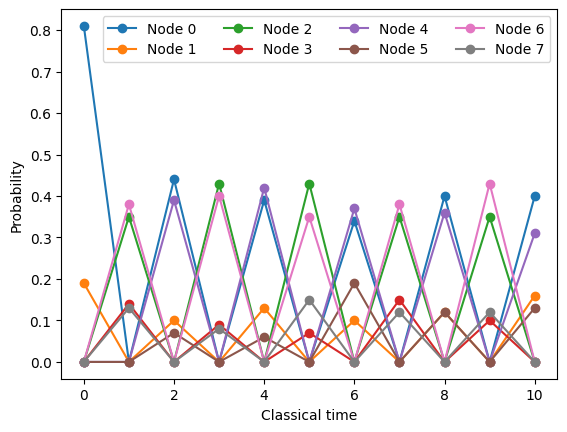

In [18]:
measured_positions = [[0,1,2]] + [[1,2,3]]*final_classical_time

simplified_decrypted_counts = [cqc.decrypt_counts(simplified_homomorphic_counts[tc],measured_positions[tc]) for tc in range(final_classical_time+1)]

simplified_decrypted_distributions_matrix = counts_to_step_probability_distributions(simplified_decrypted_counts)

plt.plot(simplified_decrypted_distributions_matrix,'-o')
plt.xlabel('Classical time')
plt.ylabel('Probability')
plt.legend(['Node '+str(n) for n in range(distributions_matrix.shape[1])],ncols=4,loc=1)
plt.show()

<a name='5'></a>
## 5 - Deterministic simulation with SQUWALS

Finally we show the results obtained deterministically using SQUWALS [[3]](https://onlinelibrary.wiley.com/doi/full/10.1002/qute.202400022). This python library can be downloaded at https://github.com/OrtegaSA/SQUWALS-repo.

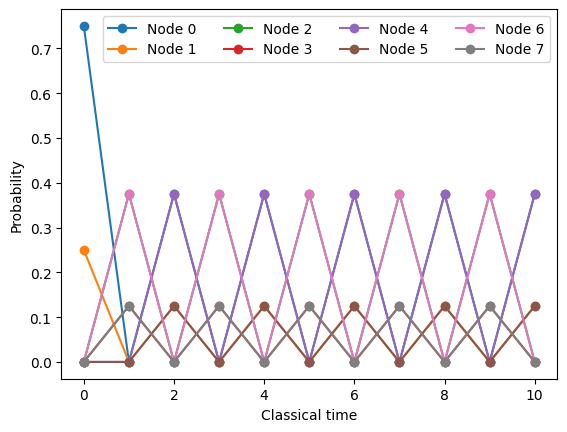

In [19]:
import squwals as sw
import networkx as nx

# Number of nodes of the cycle graph.
N = 8

# Transition matrix G.
graph = nx.cycle_graph(N)
G = nx.to_numpy_array(graph)
G = G/sum(G)

# Semiclassical transition matrices.
semiclassical_matrices = sw.semiclassical_szegedy_simulator(transition_matrix=G,time_steps=2,measure=1,monitor=False)
# Take the semiclassical matrix for tq = 2.
semiclassical_matrix = semiclassical_matrices[2]

# Initial classical distribution.
p1 = 0.25
p0 = 1-p1
initial_distribution = np.array([p0,p1,0,0,0,0,0,0])

# Classical walk simulation with the semiclassical transition matrix.
deterministic_distributions_matrix = sw.classical_walk_simulator(transition_matrix=semiclassical_matrix,time_steps=10,initial_distribution=initial_distribution)

# Plot the results.
plt.plot(deterministic_distributions_matrix,'-o')
plt.xlabel('Classical time')
plt.ylabel('Probability')
plt.legend(['Node '+str(n) for n in range(N)],ncols=4,loc=1)
plt.show()

<a name='6'></a>
## 6 - References

- [1] **[S. A Ortega and M. A. Martin-Delgado. Discrete-time Semiclassical Szegedy Quantum Walks. Physica A, 625:129021, 2023.](https://www.sciencedirect.com/science/article/pii/S0378437123005769)**
- [2] **[S. A Ortega, P. Fernández and M. A. Martin-Delgado. Implementing Semiclassical Szegedy Walks in Classical-Quantum Circuits for Homomorphic Encryption. arXiv:2412.01966](https://arxiv.org/abs/2412.01966)**
- [3] **[S. A Ortega and M. A. Martin-Delgado. SQUWALS: A Szegedy QUantum WALks Simulator. Advanced Quantum Technologies, 2400022, 2024.](https://onlinelibrary.wiley.com/doi/full/10.1002/qute.202400022)**